# CS 4442 Assignment 3
#### Shaan Verma
#### 250804514

### Packages to be used in both problems 2 and 3

In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from scipy import signal as sig
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.feature import peak_local_max, corner_harris, corner_peaks

### Predefined functions

In [2]:
# Turns image into a Numpy array
def imageToArray(picture):
    img = Image.open(picture)
    img = ImageOps.grayscale(img)
    return np.array(img)

# Turns Numpy array to an image
def arrayToImage(array,name):
    img = Image.fromarray(array)
    img = img.convert('1')
    img.save(name + '.jfif')

# Creates a Gaussian matrix and calculates patial derivatives
def gaussianKernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    
    dx = (-x/sigma**2)*g 
    dy = (-y/sigma**2)*g 
    return g, dy, dx

# Vertical part of the convolution kernel
def vertical(image,kernel):
    count = len(kernel)//2
    
    newImage = np.zeros(image.shape)
    padding = np.zeros((1,image.shape[1]))
    
    holder = np.vstack((padding, image))
    holder = np.vstack((holder,padding))
    
    for zeros in np.arange(0,count-1,1):
        holder = np.vstack((padding, holder))
        holder = np.vstack((holder,padding))
        
    holder = holder.T
    
    for i in np.arange(0,image.shape[1],1):
        for j in np.arange(0,image.shape[0],1):
            temp = []
            for k in np.arange(0,len(kernel),1):
            #temp = np.array([holder[i][j], holder[i][j+1], holder[i][j+2]])
                temp.append(holder[i][j+k])
            temp = np.multiply(temp, kernel)
            
            value = np.sum(temp)
            newImage[j][i] = value
            
    return newImage

# Horizontal part of the convolution kernel
def horizontal(image,kernel):
    count = len(kernel)//2
    newImage = np.zeros(image.shape)
    padding = np.zeros((image.shape[0],1))
    holder = np.hstack((padding, image))
    holder = np.hstack((holder,padding))
    
    for zeros in np.arange(0,count-1,1):
        holder = np.hstack((padding, holder))
        holder = np.hstack((holder,padding))
        
    
    for i in np.arange(0,image.shape[0],1):
        for j in np.arange(0,image.shape[1],1):
            temp = []
            for k in np.arange(0,len(kernel),1):
            #temp = np.array([holder[i][j], holder[i][j+1], holder[i][j+2]])
                temp.append(holder[i][j+k])
            temp = np.multiply(temp, kernel)
            
            value = np.sum(temp)
            newImage[i][j] = value
           
    return newImage

# Calculates non-max suppression to be used in problem 2 to eliminate pixels that are not local maxima
# of the magnitude in the direction of the gradient.
# Function taken from: 
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

### Problem 2 - Edge Detection

In [3]:
def problem2(image, sigma, low, high):
    
    # Importing image and converting to array
    image = imageToArray(image)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(image,cmap='gray')
    
    # Gaussian kernal and its partial derivatives
    kernel, dy, dx = gaussianKernel(5,sigma)
    
    # Grabing 5th row to be used in separable convolution 
    x_y = kernel[4]
    
    # Convolution in two steps
    vertical_output = vertical(image, x_y)
    final_output = horizontal(vertical_output, x_y)
    plt.figure()
    plt.title('Gaussian Smoothing sigma='+str(sigma))
    plt.axis('off')
    plt.imshow(final_output,cmap='gray')
    
    # Derivative of image wrt y
    column_y = dy[:,0]
    row_y = dy[0]
    Iy = vertical(final_output, column_y)
    Iy = horizontal(Iy, row_y)
    plt.figure()
    plt.title('Derivative wrt Y')
    plt.axis('off')
    plt.imshow(Iy,cmap='gray')
    
    # Derivative of image wrt x
    column_x = dx[:,0]
    row_x = dx[0]
    Ix = vertical(final_output, column_x)
    Ix = horizontal(Ix, row_x)
    plt.figure()
    plt.title('Derivative wrt X')
    plt.axis('off')
    plt.imshow(Ix,cmap='gray')
    
    # Calculating magnitude direction
    G = np.hypot(Ix,Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    plt.figure()
    plt.title('Gradient Intensity')
    plt.axis('off')
    plt.imshow(G,cmap='gray')
    
    #Eliminating pixels that are not local max
    suppression = non_max_suppression(G,theta)
    plt.figure()
    plt.title('Non-Max Suppression')
    plt.axis('off')
    plt.imshow(suppression,cmap='gray')
    
    # Hysteresis Thresholding
    finalImage = filters.apply_hysteresis_threshold(suppression, low, high)
    plt.figure()
    plt.title('Binary Threshold Hystersis:' + 'low=' + str(low) + ' high=' + str(high))
    plt.axis('off')
    plt.imshow(finalImage,cmap='gray')

### Use this function to run and change the parameters

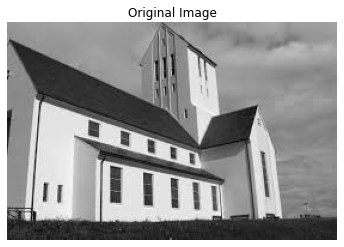

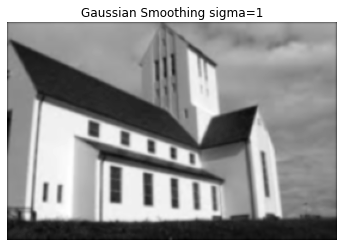

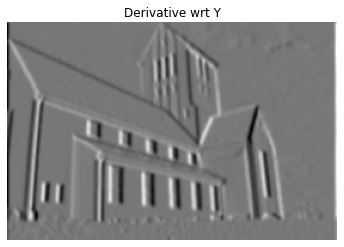

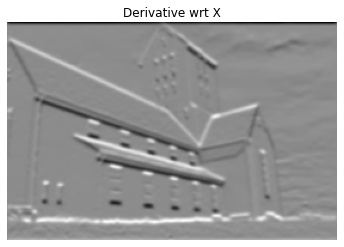

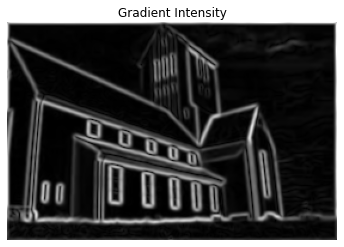

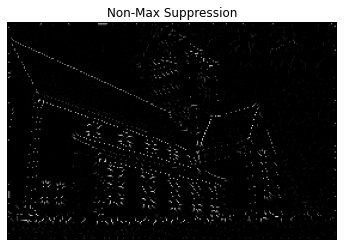

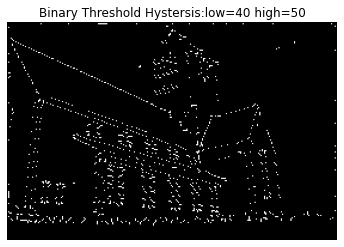

In [4]:
problem2('image1.jfif', 1, 40, 50)

### Problem 3 - Corner Detection

##### Importing image and converting to array

In [5]:
#Importing image and converting to array
image = imageToArray('image1.jfif')

##### Spatial derivative calculation

In [6]:
# Sobel operator kernels.
kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
Ix = sig.convolve2d(image, kernel_x, mode='same')

kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
Iy = sig.convolve2d(image, kernel_y, mode='same')

##### Structure tensor setup (M)

In [7]:
Ixx = ndi.gaussian_filter(Ix**2, sigma=1)
Ixy = ndi.gaussian_filter(Iy*Ix, sigma=1)
Iyy = ndi.gaussian_filter(Iy**2, sigma=1)

##### Corner response calculation

In [8]:
k = 0.05
detA = Ixx * Iyy - Ixy ** 2
traceA = Ixx + Iyy
harris_response = detA - k * traceA ** 2

##### Non-maximum suppression

(-0.5, 275.5, 181.5, -0.5)

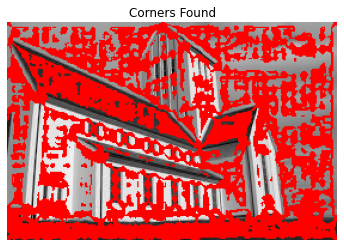

In [9]:
# Getting original image
original_img = imread('image1.jfif')

# Copy of original image to hold corner and edge points
imgCorners = np.copy(original_img)
imgEdges = np.copy(original_img)

# Finding edges and corners using the response value
# r > 0 is a corner
# r < 0 is an edge
for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            imgCorners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            imgEdges[rowindex, colindex] = [0,255,0]

plt.imshow(imgCorners)
plt.title("Corners Found")
plt.axis('off')

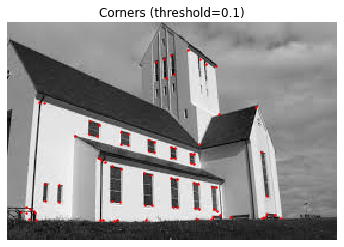

In [10]:
# Find the local maxima of the peaks
threshold = 0.1
cornersMax = corner_peaks(harris_response,threshold_rel=threshold)

plt.imshow(original_img, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Corners (threshold=' + str(threshold) + ')')
plt.axis('off')
plt.plot(cornersMax[:, 1], cornersMax[:, 0], '.r', markersize=3)